In [1]:
%cd "/gscratch/xlab/alisaliu/hack-tokenizers"

/mmfs1/gscratch/xlab/alisaliu/hack-tokenizers


/gscratch/cse/alisaliu/miniconda3/envs/playground/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from pathlib import Path
import json
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import normal
import pandas as pd
from collections import defaultdict
from utils import read_tokenizer_json, read_merges_txt, read_predictions, read_json, score_solution, mse
from train_mixed_tokenizer import sample_from_unit_simplex
from constants import CODE_TO_LANG

In [3]:
from matplotlib import font_manager
import colorsys
import matplotlib.colors as mcolors

font_dir = ["../FONTS"]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

plt.rcParams.update({
    "font.family": "Macho",
    "axes.linewidth": 1.5,
    "axes.edgecolor": "#333333",
    "axes.labelcolor": "#333333",
    "axes.titlecolor": "#333333",
    "xtick.color": "#333333",
    "ytick.color": "#333333",
    "legend.labelcolor": "#333333",
    "text.color": "#333333",
    "font.size": 14,
    "font.weight": 'semibold',
})

In [4]:
LLM_TOKENIZERS = ['gpt2', 'gpt3.5', 'gpt4o', 'llama', 'llama3-rollup', 'mistral', 'mistral-nemo', 'gpt-neox', 'claude', 'gemma']

In [5]:
LATIN_CYRILLIC_LANGS = ['bg', 'ca', 'cs', 'da', 'de', 'es', 'fr', 'hu', 'it', 'nl', 'pl', 'pt', 'ro', 'ru', 'sl', 'sr', 'sv', 'uk']

# LLM predictions

In [6]:
def read_correct_file(filenames):
    """
    There are a few possible filenames for each solution, because of... reasons.
    """
    for f in filenames:
        try:
            return read_predictions(f)
        except FileNotFoundError:
            continue

In [7]:
data_dir = Path('experiments/llm_tokenizers')
preds = {}
for model_name in LLM_TOKENIZERS:
    filenames = ['solution6_pairs_30000.json', 'solution6_pairs_29473.json', 'solution6_pairs_28417.json', 'solution6_pairs_27745.json']
    preds[model_name] = read_correct_file([data_dir / model_name / f for f in filenames])

In [8]:
def hex_to_hsl(hex_color):
    hex_color = hex_color.lstrip("#")
    r, g, b = (
        int(hex_color[:2], 16) / 255,
        int(hex_color[2:4], 16) / 255,
        int(hex_color[4:], 16) / 255,
    )
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return h, s, l

def change_lightness(hex_color, factor=1.0, delta=0.0):
    assert factor == 1.0 or delta == 0.0
    h, s, l = hex_to_hsl(hex_color)
    l = min(1, max(0, l * factor + delta))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return "#{:02x}{:02x}{:02x}".format(int(r * 255), int(g * 255), int(b * 255))

In [9]:
GPT_COLOR = "#90d5ae"
GPT_NEOX_COLOR = "#EC9D95"
LLAMA_COLOR = "#bf94d1"
CLAUDE_COLOR = "#c28f70"
GEMMA_COLOR = "#70a0c2"
MISTRAL_COLOR = "#F5B253"
COMMANDR_COLOR = '#3B5047'

In [10]:
attribute_codes = {
    'web': 'Web',
    'github': 'Code',
    'books': 'Books',
    'arxiv': 'Academic',
    'wikipedia': 'Wiki',
    'es': 'Spanish',
    'en': 'English',
    'fr': 'French',
    'ru': 'Russian',
    'de': 'German',
    'ar': 'Arabic',
    'zh': 'Chinese',
    'ja': 'Japanese',
    'latin_cyrillic': 'Languages with\nLatin + Cyrillic scripts',
    'other': 'Other languages'
}

model_codes = {
    'gpt2': 'GPT-2',
    'gpt3.5': 'GPT-3.5',
    'gpt4o': 'GPT-4o',
    'gpt-neox': 'GPT-NeoX',
    'llama': 'Llama',
    'llama3-rollup': 'Llama 3*',
    'gemma': 'Gemma',
    'claude': 'Claude',
    'mistral': 'Mistral',
    'mistral-nemo': 'Mistral NeMo',
    'command-r': 'Command R'
}

In [11]:
palette = {
    'gpt2': change_lightness(GPT_COLOR, delta=0.25),
    'gpt3.5': change_lightness(GPT_COLOR, delta=0.15),
    'gpt4o': GPT_COLOR,
    'llama': change_lightness(LLAMA_COLOR, delta=0.2),
    'llama3-rollup': LLAMA_COLOR,
    'gpt-neox': GPT_NEOX_COLOR,
    'claude': CLAUDE_COLOR,
    'gemma': GEMMA_COLOR,
    'mistral': change_lightness(MISTRAL_COLOR, delta=0.2),
    'mistral-nemo': MISTRAL_COLOR,
    'command-r': COMMANDR_COLOR
}
palette = {model_codes[m]: c for m, c in palette.items()}

In [12]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches[:-len(LLM_TOKENIZERS)]:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.03
            value = '{:d}'.format(round(p.get_height()*100))
            ax.text(_x, _y, value, ha="center", fontweight='normal')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

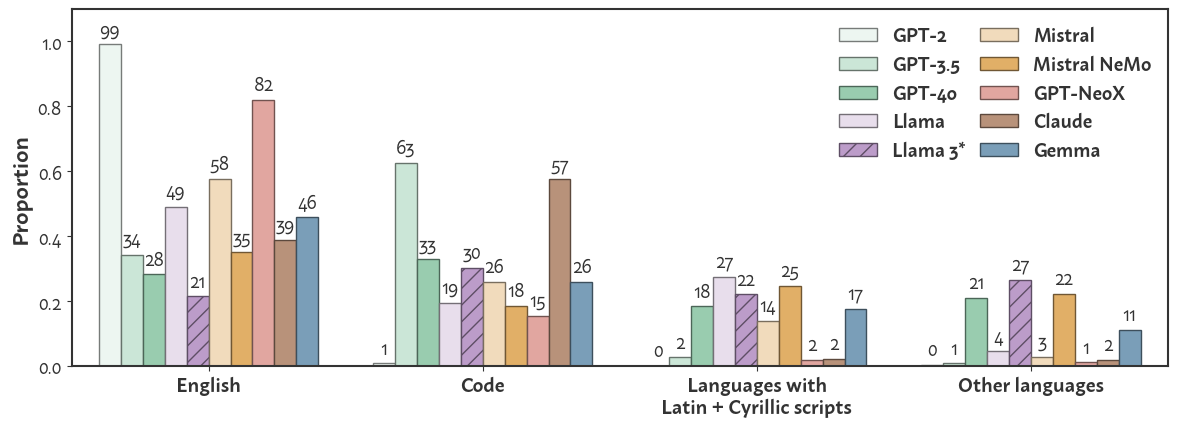

In [13]:
langs_to_plot = ['en', 'github', 'latin_cyrillic', 'other']
en_domains = ['web', 'books', 'wikipedia', 'arxiv']
# models_to_show = ['gpt2', 'gpt3.5', 'gpt4o', 'llama', 'llama3-rollup', 'mistral', 'mistral-nemo', 'gpt-neox', 'claude', 'gemma']  # this is just for making intermediate transition slides in Keynote
models_to_show = LLM_TOKENIZERS

fig, ax = plt.subplots(figsize=(12, 4.5))
sub_dfs = []
for i, model_name in enumerate(LLM_TOKENIZERS):
    data_df = pd.DataFrame(columns=['language', 'pred'])
    langs = [attribute_codes[l] for l in langs_to_plot]

    if model_name not in models_to_show:
        props = [0, 0, 0, 0]
    else:
        props = [
            sum([preds[model_name][x] for x in en_domains]),  # English
            preds[model_name]['github'],  # code
            sum([preds[model_name][x] for x in preds[model_name] if x in LATIN_CYRILLIC_LANGS]),  # langs with Latin + Cyrillic scripts
            sum([preds[model_name][x] for x in preds[model_name] if x not in ['github'] + en_domains + LATIN_CYRILLIC_LANGS])  # other
        ]
    
    data_df['language'] = langs
    data_df['prop'] = props
    data_df['model'] = model_codes[model_name]
    sub_dfs.append(data_df)

df = pd.concat(sub_dfs)
ax = sns.barplot(x='language', y='prop', data=df, hue='model', palette=palette)

for bar in ax.patches:
    facecolor = bar.get_facecolor()
    
    # Convert the face color to an RGB tuple
    facecolor_rgb = mcolors.to_rgb(facecolor)
    
    # Darken the face color to create a border color
    edgecolor = tuple([max(0, c * 0.5) for c in facecolor_rgb])
    bar.set_edgecolor(edgecolor)
    bar.set_linewidth(1.0)  # You can adjust the width of the border here

llama3_index = LLM_TOKENIZERS.index('llama3-rollup')
for i in list(range(len(langs_to_plot)*llama3_index, len(langs_to_plot)*(llama3_index+1))) + [-(len(LLM_TOKENIZERS) - llama3_index)]:
    ax.patches[i].set_hatch('//')

show_values_on_bars(ax)
ax.set_ylabel('Proportion', fontsize=16, fontweight='semibold')
ax.set_xlabel('')
ax.set_ylim(top=1.1)
# ax.legend(bbox_to_anchor=(1.01,-0.1), fancybox=True, ncol=len(LLM_TOKENIZERS), fontsize=14)
ax.legend(fontsize=13.5, frameon=False, ncol=2, columnspacing=0.8)
# ax.set_title('Our Inference for LLM Tokenizers', fontweight='semibold', fontsize=20)
plt.yticks(fontweight='normal')
plt.tight_layout()
plt.savefig('plots/llm_tokenizer_dist.pdf', dpi=300)
plt.savefig('plots/llm_tokenizer_dist.png', dpi=300)

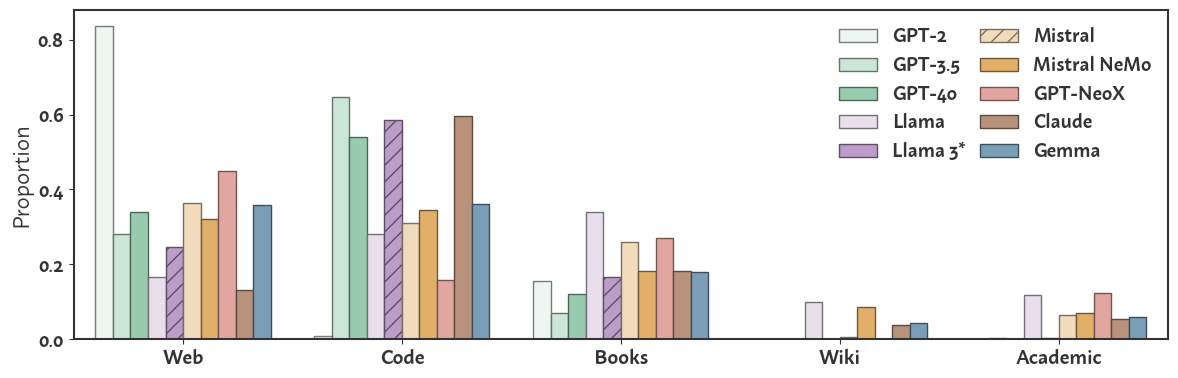

In [16]:
langs_to_plot = ['web', 'github', 'books', 'wikipedia', 'arxiv']

fig, ax = plt.subplots(figsize=(12, 4))
sub_dfs = []
for i, model_name in enumerate(LLM_TOKENIZERS):
    data_df = pd.DataFrame(columns=['language', 'pred'])
    langs, props = [], []
    for l in langs_to_plot:
        langs.append(attribute_codes[l])
        props.append(preds[model_name][l] / np.sum([preds[model_name][x] for x in en_domains + ['github']]))
    data_df['language'] = langs
    data_df['prop'] = props
    data_df['model'] = model_codes[model_name]
    sub_dfs.append(data_df)

df = pd.concat(sub_dfs)
sns.barplot(x='language', y='prop', data=df, hue='model', palette=palette)

for bar in ax.patches:
    facecolor = bar.get_facecolor()
    
    # Convert the face color to an RGB tuple
    facecolor_rgb = mcolors.to_rgb(facecolor)
    
    # Darken the face color to create a border color
    edgecolor = tuple([max(0, c * 0.5) for c in facecolor_rgb])
    bar.set_edgecolor(edgecolor)
    bar.set_linewidth(1.0)  # You can adjust the width of the border here

llama3_index = LLM_TOKENIZERS.index('llama3-rollup')
for i in list(range(len(langs_to_plot)*llama3_index, len(langs_to_plot)*(llama3_index+1))) + [-llama3_index-1]:
    ax.patches[i].set_hatch('//')
    
ax.set_ylabel('Proportion', fontsize=16)
ax.set_xlabel('')
ax.legend(fontsize=13.5, frameon=False, ncol=2, columnspacing=0.8)
plt.tight_layout()
plt.savefig('plots/llm_tokenizer_domain_dist.pdf', dpi=300)
plt.savefig('plots/llm_tokenizer_domain_dist.png', dpi=300)

In [33]:
# proportion of non-English text
model_name = 'gpt4o'
non_english = sum([v for k, v in preds[model_name].items() if k not in en_domains + ['github']])
en_sum = np.sum([preds[model_name][x] for x in en_domains])
print(f"non-English: {np.round(non_english, 4)}")
print(f'English: {np.round(en_sum, 4)}')

non-English: 0.3904
English: 0.2811


In [32]:
# proportion of different domains
model_name = 'gpt4o'
for d in en_domains:
    print(f'{d}: {np.round(preds[model_name][d], 4)}')

web: 0.2072
books: 0.0737
wikipedia: 0.0
arxiv: 0.0002


In [23]:
# number of natural languages that make up at least 0.1% of the data (excluding English)
len([l for l, p in preds['gpt4o'].items() if (p > 0.001) and (l not in en_domains + ['github'])])

67

In [34]:
# proportion of the training data made up of code + languages that use the Latin or Cyrillic script
model_name = 'mistral'
lang_sum = 0
for lang in en_domains + ['github'] + LATIN_CYRILLIC_LANGS:
    lang_sum += preds[model_name][lang]

lang_sum

0.9728311306228425

In [26]:
# Mistral is heavily biased toward a handful of languages
model_name = 'mistral'
lang_sum = 0
for lang in en_domains + ['github'] + ['fr', 'es', 'it', 'de']:
    lang_sum += preds[model_name][lang]

lang_sum

0.9104601965811099

In [27]:
# all categories, sorted by frequency
model_name = 'mistral-nemo'
{k: preds[model_name][k] for k in sorted(preds[model_name], key=preds[model_name].get, reverse=True)}

{'github': 0.18343261846574319,
 'web': 0.1712749133586066,
 'books': 0.09634978876895696,
 'fr': 0.06313833610319682,
 'ar': 0.0479840844286956,
 'wikipedia': 0.04592849925134775,
 'es': 0.03732343704677059,
 'arxiv': 0.03659991188581626,
 'de': 0.03242814259458707,
 'ru': 0.026242613572178636,
 'ko': 0.025022046268947374,
 'ja': 0.01901370023374297,
 'it': 0.016504673248700058,
 'pt': 0.014895268739600636,
 'fa': 0.011667251948444202,
 'hi': 0.009576501787354221,
 'ca': 0.008547716128283506,
 'pl': 0.007885167925969565,
 'el': 0.0073643948679823976,
 'vi': 0.006349448107675102,
 'sr': 0.006293483800675541,
 'nl': 0.006260093276002718,
 'uk': 0.0056572488100810865,
 'cs': 0.0052866436350811835,
 'gl': 0.0052624258315674835,
 'hy': 0.005134643465601754,
 'te': 0.004962385070545621,
 'bn': 0.004550037039846007,
 'tr': 0.0044314818225197625,
 'bg': 0.004265933677100217,
 'he': 0.004215788856377354,
 'ro': 0.003937618267918853,
 'id': 0.003910625277358839,
 'nds': 0.003695886407494816,
 '

# Full LLM predictions latex table

In [77]:
# order categories by max of proportions across models
all_categories = preds['gpt4o'].keys()
lang_sums = {l: max([preds[m][l] for m in LLM_TOKENIZERS]) for l in all_categories}
lang_order = sorted(lang_sums, key=lang_sums.get, reverse=True)

row = '\\textbf{Category} &'
for model_name in LLM_TOKENIZERS:
    row += f' \\textbf{{\\lm{{{model_codes[model_name]}}}}} &'

row = row.rsplit('&', 1)[0] + '\\\\\\midrule'
print(row)

for lang_code in lang_order:
    if lang_code in CODE_TO_LANG:
        row = f'{CODE_TO_LANG[lang_code]} &'
    else:
        row = f'{attribute_codes[lang_code]} &'
    
    for model_name in LLM_TOKENIZERS:
        pred = np.round(preds[model_name][lang_code]*100, 1)
        if pred < 10:
            row += f' \phantom{{0}}{pred} &'
        else:
            row += f' {pred} &'
    row = row.rsplit('&', 1)[0] + '\\\\'
    print(row)

\textbf{Category} & \textbf{\lm{GPT-2}} & \textbf{\lm{GPT-3.5}} & \textbf{\lm{GPT-4o}} & \textbf{\lm{Llama}} & \textbf{\lm{Llama 3*}} & \textbf{\lm{Mistral}} & \textbf{\lm{Mistral NeMo}} & \textbf{\lm{GPT-NeoX}} & \textbf{\lm{Claude}} & \textbf{\lm{Gemma}} \\\midrule
Web & 83.6 & 27.3 & 20.7 & 11.3 & 12.7 & 30.3 & 17.1 & 43.7 & 12.7 & 25.7 \\
Code & \phantom{0}0.7 & 62.6 & 32.8 & 19.2 & 30.2 & 25.8 & 18.3 & 15.2 & 57.5 & 25.9 \\
Books & 15.4 & \phantom{0}6.8 & \phantom{0}7.4 & 23.1 & \phantom{0}8.5 & 21.5 & \phantom{0}9.6 & 26.3 & 17.4 & 12.8 \\
Academic & \phantom{0}0.1 & \phantom{0}0.2 & \phantom{0}0.0 & \phantom{0}8.0 & \phantom{0}0.1 & \phantom{0}5.3 & \phantom{0}3.7 & 12.0 & \phantom{0}5.1 & \phantom{0}4.3 \\
Wiki & \phantom{0}0.0 & \phantom{0}0.0 & \phantom{0}0.0 & \phantom{0}6.7 & \phantom{0}0.0 & \phantom{0}0.5 & \phantom{0}4.6 & \phantom{0}0.0 & \phantom{0}3.7 & \phantom{0}3.0 \\
French & \phantom{0}0.0 & \phantom{0}0.3 & \phantom{0}2.9 & \phantom{0}5.3 & \phantom{0}1.8 & \pha

# Top 50 merges latex table

In [47]:
merges = {}
for model in LLM_TOKENIZERS:
    merges[model] = read_merges_txt(f'experiments/llm_tokenizers/{model}/merges.txt')

In [56]:
row = ''
for model_name in LLM_TOKENIZERS[5:]:
    row += f' \\textbf{{\\lm{{{model_codes[model_name]}}}}} &'

row = row.lstrip().rsplit('&', 1)[0] + '\\\\\\midrule'
print(row)

for i in range(50):
    row = ''
    for model in LLM_TOKENIZERS[5:]:
        m = merges[model][i]
        l, r = m.split(' ')
        if len(l) < len(r):
            m = '\\phantom{\_}' * (len(r) - len(l)) + m
        else:
            m = m + '\\phantom{\_}' * (len(l) - len(r))
        row += f'\\texttt{{{m}}} &'.replace('Ġ', '\_').replace('▁', '\_').replace('Ċ', '\\textbackslash{}n')
    row = row.rsplit('&', 1)[0] + '\\\\'
    print(row)

\textbf{\lm{Mistral}} & \textbf{\lm{Mistral NeMo}} & \textbf{\lm{GPT-NeoX}} & \textbf{\lm{Claude}} & \textbf{\lm{Gemma}} \\\midrule
\texttt{\_ t} &\texttt{\_ \_} &\texttt{\_ \_} &\texttt{\_ \_} &\texttt{i n} \\
\texttt{i n} &\texttt{\_ t} &\texttt{\_ t} &\texttt{\_\_ \_\_} &\texttt{\_ t} \\
\texttt{e r} &\texttt{e r} &\texttt{\_ a} &\texttt{i n} &\texttt{e r} \\
\texttt{\_ a} &\texttt{i n} &\texttt{h e} &\texttt{\_\_ \_\phantom{\_}} &\texttt{\_ a} \\
\texttt{h e} &\texttt{\_\_ \_\_} &\texttt{i n} &\texttt{\_ t} &\texttt{o n} \\
\texttt{o n} &\texttt{\_ a} &\texttt{r e} &\texttt{e r} &\texttt{r e} \\
\texttt{r e} &\texttt{e n} &\texttt{o n} &\texttt{\_\_\_\_ \_\_\_\_} &\texttt{e n} \\
\texttt{\_ s} &\texttt{o n} &\texttt{\_\_ \_\_} &\texttt{o n} &\texttt{h e} \\
\texttt{e n} &\texttt{e s} &\texttt{\_t he} &\texttt{\_ a} &\texttt{a n} \\
\texttt{a t} &\texttt{\_ s} &\texttt{e r} &\texttt{r e} &\texttt{a t} \\
\texttt{o r} &\texttt{\_ d} &\texttt{a t} &\texttt{a t} &\texttt{o r} \\
\textt

# How many merges should we consider? (§B.4.2)

In [41]:
mse_scores = {}
NUM_MERGES = [100, 300, 1000, 3000, 10000, 30000]
map = {5: 29776, 10: 29776, 30: 29780, 112: 29778}

for n in [5, 10, 30, 112]:
    experiment_dir = Path(f'experiments/mixed_languages/n_{n}')
    mse_scores[n] = defaultdict(list)
    
    for test_id in tqdm(range(100), desc=str(n)):
        for T in NUM_MERGES:
            if T == 30000:
                T = map[n]
            try:
                mse = score_solution(experiment_dir / str(test_id), f'solution6_pairs_{T}.json')
                mse_scores[n][T].append(mse)
            except FileNotFoundError:
                print(experiment_dir / str(test_id) / f'solution6_pairs_{T}.json')
                continue

112: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


In [42]:
rows = []
for n, data in mse_scores.items():
    for T, scores in data.items():
        for s in scores:
            rows.append({
                'n': n,
                'T': T,
                'MSE': s
            })

data = pd.DataFrame(rows, columns=['n', 'T', 'MSE'])

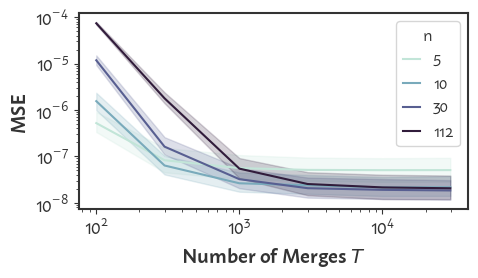

In [43]:
plt.rcParams.update({"font.weight": 'normal'})
fig, ax = plt.subplots(figsize=(5,3))
plt.xscale('log')
plt.yscale('log')
data['n'] = data['n'].apply(str)
sns.lineplot(data=data, x='T', y='MSE', hue='n', palette=sns.cubehelix_palette(start=.5, rot=-.5, n_colors=4))
ax.set_ylabel('MSE', fontweight='semibold')
ax.set_xlabel('Number of Merges $T$', fontweight='semibold')
plt.tight_layout()
leg = ax.legend(title='n', fontsize=12, title_fontsize=12, handlelength=1)
plt.savefig('plots/num_merges_scaling.pdf', dpi=300)

# How many data samples should we use from each category? (§B.4.1)

In [44]:
EXPONENTS = [6, 7, 8, 9, 10]
mse_scores = {}

for mixture_type in ['languages', 'code', 'domains']:
    experiment_dir = Path(f'experiments/mixed_{mixture_type}_analysis/n_5')
    mse_scores[mixture_type] = {10**e: [] for e in EXPONENTS}
    
    for test_id in tqdm(range(100), desc=mixture_type):
        for e in EXPONENTS:
            try:
                mse = score_solution(experiment_dir / str(test_id), f'solution6_pairs_3000_1e{e:02d}.json', num_bytes=10**e)
            except FileNotFoundError:
                print(f'Missing file for {experiment_dir}/{test_id}/solution6_pairs_3000_1e{e:02d}.json')
                continue
            
            mse_scores[mixture_type][10**e].append(mse)

domains: 100%|██████████| 100/100 [00:02<00:00, 36.27it/s]


In [45]:
mixture_col, D_col, score_col = [], [], []

for mixture_type, data in mse_scores.items():
    for D, scores in data.items():
        for s in scores:
            mixture_col.append(mixture_type)
            D_col.append(D)
            score_col.append(s)

In [46]:
data = pd.DataFrame({'mixture': mixture_col, 'D': D_col, 'MSE': score_col})

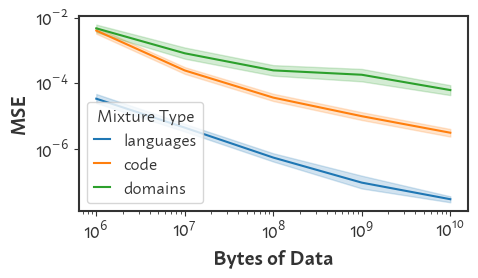

In [47]:
plt.rcParams.update({"font.weight": 'normal'})
fig, ax = plt.subplots(figsize=(5,3))
plt.xscale('log')
plt.yscale('log')
sns.lineplot(data=data, x='D', y='MSE', hue='mixture')
ax.set_ylabel('MSE', fontweight='semibold')
ax.set_xlabel('Bytes of Data', fontweight='semibold')
leg = ax.legend(title='Mixture Type', fontsize=12, title_fontsize=12, handlelength=1)
plt.tight_layout()
plt.savefig('plots/bytes_data_scaling.pdf', dpi=300)

# Visualize different MSEs

In [33]:
import string
import itertools
dummy_codes = [''.join(tup) for tup in itertools.product(string.ascii_lowercase, string.ascii_lowercase)]

In [317]:
n = 5
true = {l: p for l, p in zip(dummy_codes, sample_from_unit_simplex(n=n))}
# pred = {l: p + e for (l, p), e in zip(true.items(), normal(scale=0.01, size=n))}
# pred = {l: p + e for (l, p), e in zip(true.items(), normal(scale=0.0002, size=n))}
# pred = {l: p/sum(pred.values()) for l, p in pred.items()}
pred = {l: p for l, p in zip(dummy_codes, sample_from_unit_simplex(n=n))}
s = mse(true, pred)
log10s = np.log10(s)
log10s

-1.3604345878692192

In [318]:
true

{'aa': 0.0453, 'ab': 0.3011, 'ac': 0.1868, 'ad': 0.0905, 'ae': 0.3763}

In [319]:
pred

{'aa': 0.4424, 'ab': 0.2901, 'ac': 0.0054, 'ad': 0.0446, 'ae': 0.2175}

In [320]:
df_rows = []
for lang in true.keys():
    df_rows.append({
        'prop': true[lang],
        'label': 'Truth',
        'lang': lang
    })
    df_rows.append({
        'prop': pred[lang],
        'label': 'Prediction',
        'lang': lang
    })

data_df = pd.DataFrame(df_rows)
data_df

,prop,label,lang
0,0.0453,Truth,aa
1,0.4424,Prediction,aa
2,0.3011,Truth,ab
3,0.2901,Prediction,ab
4,0.1868,Truth,ac
5,0.0054,Prediction,ac
6,0.0905,Truth,ad
7,0.0446,Prediction,ad
8,0.3763,Truth,ae
9,0.2175,Prediction,ae


/tmp/ipykernel_90117/2656634938.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(1, 11))


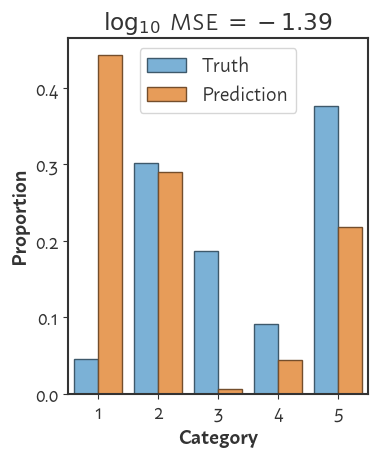

In [321]:
plt.rcParams.update({
    "font.weight": 'normal',
})

fig, ax = plt.subplots(figsize=[4, 4.8])
sns.barplot(data=data_df, hue='label', x='lang', y='prop', palette=['#6cb4e5', '#ff9a41'])
ax.set_xlabel('Category', fontweight='semibold')
ax.set_ylabel('Proportion', fontweight='semibold')
ax.set_xticklabels(np.arange(1, 11))

for bar in ax.patches:
    facecolor = bar.get_facecolor()
    
    # Convert the face color to an RGB tuple
    facecolor_rgb = mcolors.to_rgb(facecolor)
    
    # Darken the face color to create a border color
    edgecolor = tuple([max(0, c * 0.5) for c in facecolor_rgb])
    bar.set_edgecolor(edgecolor)
    bar.set_linewidth(1.0)  # You can adjust the width of the border here

ax.legend(title='')
ax.set_title('$\log_{10}$ MSE $= -1.39$')
plt.tight_layout()
plt.savefig('plots/example_logmse-1.png', dpi=300)